# <center>Atari Games with Q-Learning</center>

<center> by Kirill Tkachuk<br>January 2021<br><br>

<center>In this notebook I will show how to train a reinforcement learning model to play Atari games. The approach that I will use in this notebook is based on the paper <b>Playing Atari with Deep Reinforcement Learning</b> by Mnih et al. from 2013. However, I will also add some recent state-of-the-art improvements, which I will discuss later. Since it is one of the most known games I have decided to pick the game "Breakout" for the showcase, which is shown in the Gif blow.

<img src="atari.gif" width="300" align="center">

<center>The model will be trained with the method called $Q$-Learning. In this method the model tries to predict the $Q$-Value for a given action in a given state. The $Q$-Value stands for the "quality" of an action and the function $Q$ which outputs such $Q$-Values is called "action value function". $Q$-Values describe the sum of future rewards that the model expects to get if it takes certain a action $a$ in a given state $s$. 

$$\Large Q(a_t, s_t) =\sum_{t'= t}^T \mathbb{E} (r(a_{t'}, s_{t'})) $$

<center>The optimal action value function can be described with the Bellman equation.

$$\Large Q^*(a_t,s_t) = r(a_t,s_t) + \gamma \sum_{s_t'} p(s_{t'} | s_t, a_t)\  \underset{a_{t'}}{max}\ Q(s_{t'}, a_{t'})$$

<center>To put this equation in simple words: The optimal $Q$-Value of an action consists of the reward that the model gets for picking this action plus the discounted maximal $Q$-Value of the next state. The discount factor $\gamma$ discounts rewards which come later in the future and prevents the $Q$-Values from exploding in cases of infinite trajectories. 

<center>The model that we will build will estimate such an action value function. For this we will use a neural network, which was proposed by Mnih et al. in 2013 and is called Deep Q Network (DQN). The trained model can then be used to play an Atari game. The model will select the best action by picking the action with the highest $Q$-Value in every given state. 

<center>Lets begin with importing all modules that we need. To simulate the Atari game we will use the OpenAi's gym environment. Gym can be installed with !pip install gym and !pip install gym[atari] for the Atari games 

In [ ]:
import numpy as np
import tensorflow as tf
import gym
import copy
from datetime import datetime
import os
import pickle as pkl
import gc
import time

<center><b>Note: All code in this notebook is written in a fashion to decrease the amount of python loops and python objects, because these often have a negative impact on the performance compared to numpy and tensorflow functions, which are often written in C.

---

## <center> Model

<center>Now let us define the model. The model will have 2 convolutional (3D) layers and one hidden dense layer. The architecture is depicted in the following illustrations. For better training the input of the model will consist of $n$ = 4 stacked frames which will represent one state. The convolutional layers will convolve frame after frame, therefore 3D convolutional layers are used with a stride of one on the last axis. Optionally a 2D convolution can be used where the single frames are the channels.

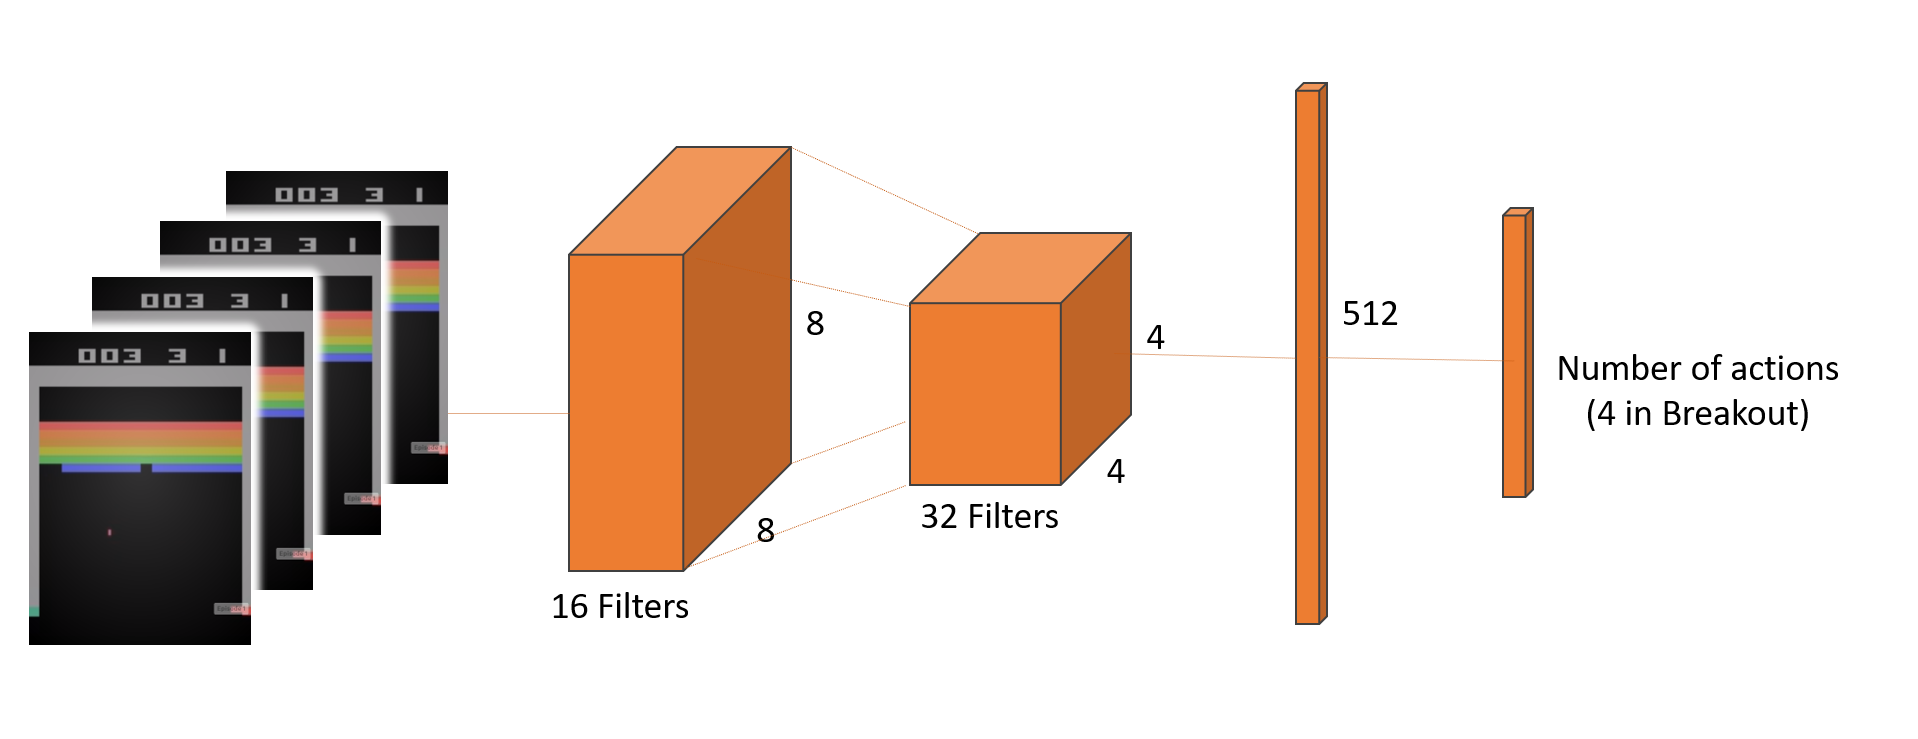

<center>The model will be defined in Tensorflow 2. The hidden layers will use ReLu activations.

In [ ]:
class DQN(tf.keras.Model):
    def __init__(self,  output_size):
        super(DQN, self).__init__()
        self.conv1 = tf.keras.layers.Conv3D(16, (8, 8, 1), strides=(4, 4, 1), activation=tf.keras.activations.relu)
        self.conv2 = tf.keras.layers.Conv3D(32, (4, 4, 1), strides=(2, 2, 1), activation=tf.keras.activations.relu)
        self.flat = tf.keras.layers.Flatten()
        self.hidden = tf.keras.layers.Dense(256, activation= tf.keras.activations.relu)
        self.out = tf.keras.layers.Dense(output_size)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flat(x)
        x = self.hidden(x)
        x = self.out(x)
        return x

---

## <center> Replay Buffer

<center>Now we will define the replay buffer. The replay buffer will store the experiences (observation of the current state, action picked in that state, reward, observation of the next state, flag if state is terminal) which the agent will collect. These experiences will then later be randomly sampled from the buffer for every training step. This approach breaks the correlation between the experiences and ensures a more stable training. 

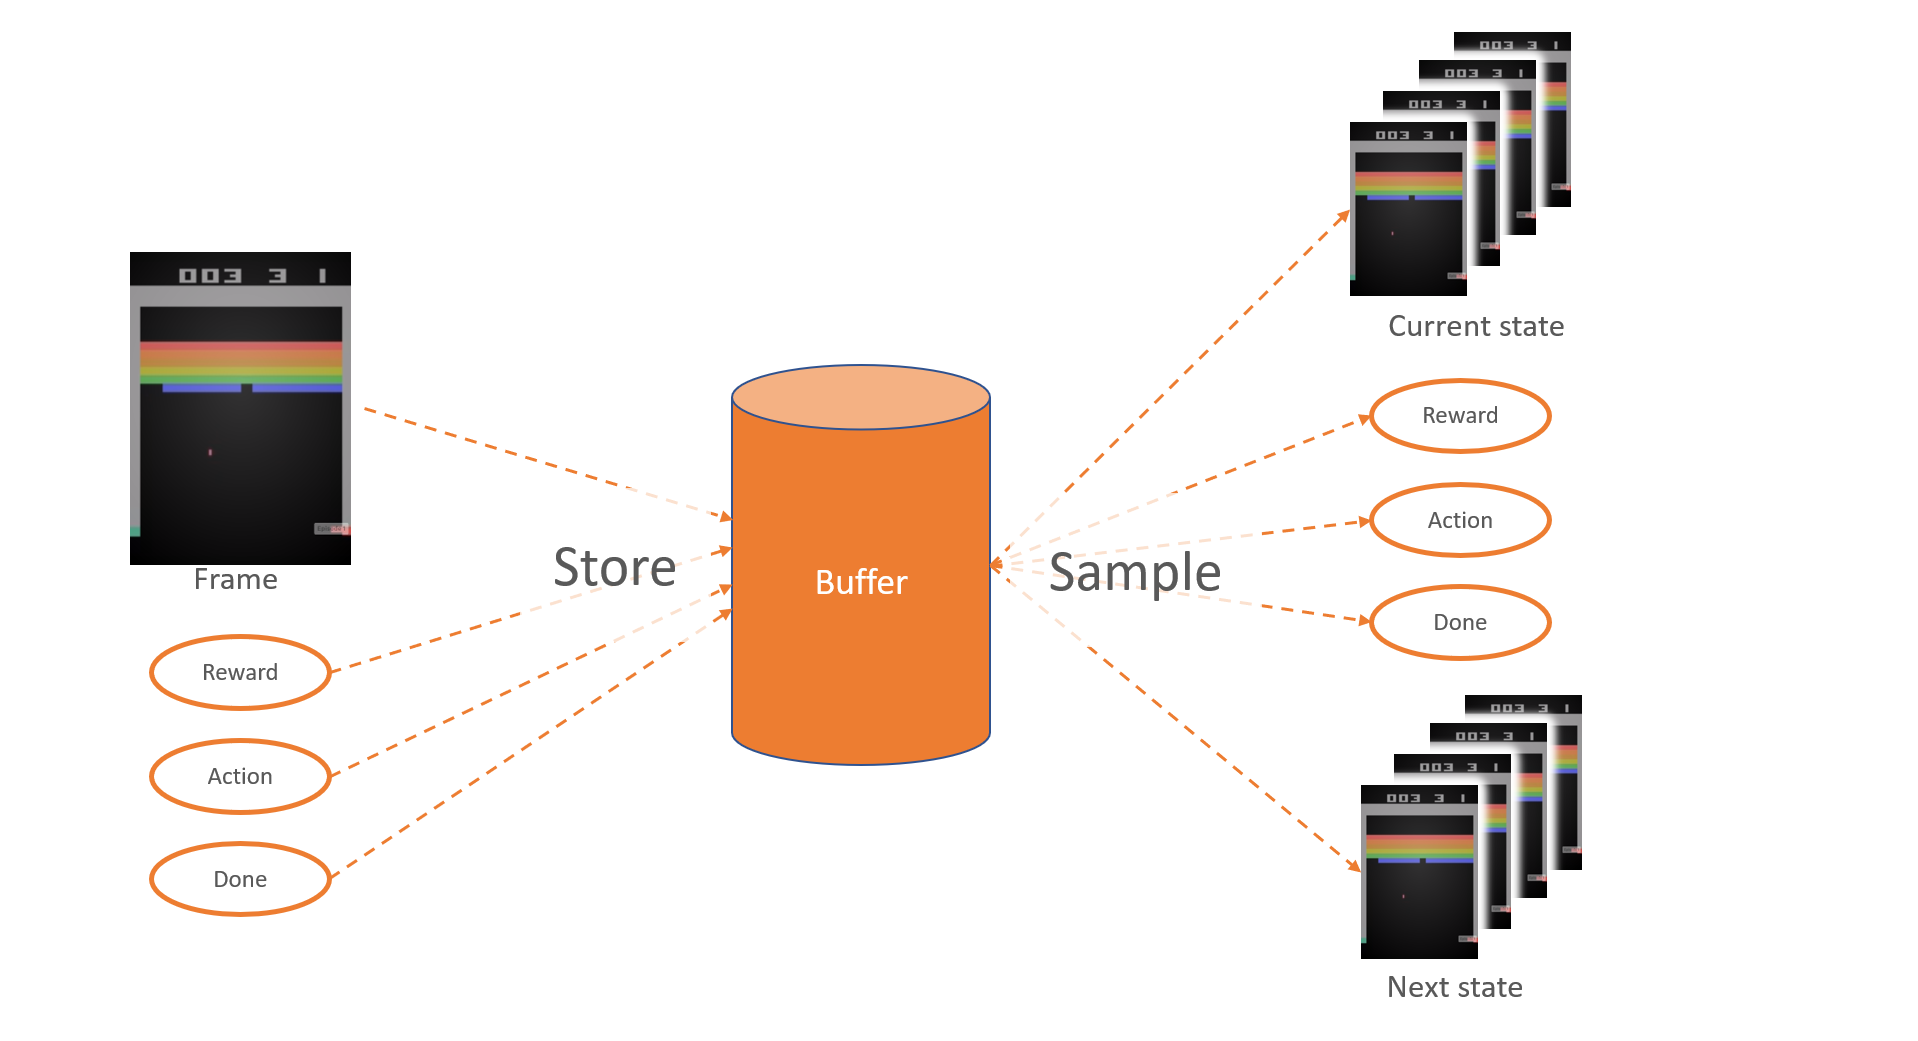

In [ ]:
class ReplayBuffer():
    """
    Memory buffer for experience replay of transitions in episodes
    
    Args:
        size: max capacity of the buffer
        img_size: shape of the input image
        n_frames: number of frames per observation
    """
    def __init__(self, size, img_size = (84,84,1), n_frames = 4):
        self.size = size
        self.observations = np.empty((size,*img_size),dtype = np.float32)
        self.rewards = np.empty((size), dtype = np.int32)
        self.actions = np.empty((size), dtype = np.int32)
        self.terminal = np.empty((size),dtype = np.bool)
        self.sampling_forbidden = np.empty((size),dtype = np.bool)
        self.n_frames = n_frames
        self.idx = 0
        self.full = False
      
    
    def store(self, observation, action, reward, done):
        """
        Store an experience in buffer
        
        Args:
            observation: frame (image) from the game 
            action: picked action
            reward: observed reward
            done: info if state is terminal
        """
        self.observations[self.idx,:,:,0] = observation
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.terminal[self.idx] = done
        
        #Forbid sampling of frames that are next to the terminal frame
        #so the sample does not overflow to the next episode
        if done == False:
            self.sampling_forbidden[self.idx] = done
        else:
            self.sampling_forbidden[max(0,self.idx-(self.n_frames-2)):self.idx+1] = done  
        
        if self.idx == self.size - 1:
            self.full = True
        self.idx =  (self.idx + 1) % self.size
      
    
    def sample(self, batch):
        """
        Sample a batch of experiences (tensors)
        
        Args:
            batch: size of the sample batch
        """
        #Get indices for the sample
        if self.full:
            idx = np.random.choice(np.where(self.sampling_forbidden[:(-1 * self.n_frames*2)] == False)[0], batch)
        else:
            idx = np.random.choice(np.where(self.sampling_forbidden[:self.idx-(self.n_frames*2 + 1)] == False)[0], batch) 
        
        #Get data and stack frames for the observations
        #Convert to TF Tensors
        obs =  tf.convert_to_tensor(np.stack([self.observations[idx + i] for i in range(self.n_frames) ], axis = -2),
                                    dtype=tf.float32)
        r = tf.convert_to_tensor(np.clip(self.rewards[idx+(self.n_frames-1)], -1, 1),
                                 dtype=tf.float32) 
        a = tf.convert_to_tensor(self.actions[idx + (self.n_frames-1)],
                                 dtype=tf.int32)
        t = tf.convert_to_tensor(self.terminal[idx + (self.n_frames-1)],
                                 dtype=tf.float32)
        next_obs = tf.convert_to_tensor(np.stack([self.observations[idx + i +self.n_frames] for i in range(self.n_frames) ], axis = -2),
                                        dtype=tf.float32)
        return obs, r, a, t, next_obs
    
    
    def can_provide_batch(self,batch):
        """
        Checks if buffer can provide batch of given size
        
        Args:
            batch: size of the sample batch
        """
        if self.full:
            return self.size >= batch
        else: 
            return self.idx >= batch

---

## <center> Preprocessing

<center>The original images have the size of 210 x 160 pixels and 3 channels (RGB). To store many of such images we would need a lot of memory. Therefore we will downscale them to the size of 110 x 84 pixels, then crop a 84 x 84 area and at last convert them to grayscale. The following helper function is used for the preprocessing.

In [ ]:
def preprocess_image(image):
    """
    Rescale a given image to the size of 84 x 84 and convert to grayscale

    Args:
        image: Input image to be processed
    """
    img = tf.image.rgb_to_grayscale(tf.image.resize(image, (110,84)))
    img = tf.squeeze(img)[18:102]
    return img

<center><div>
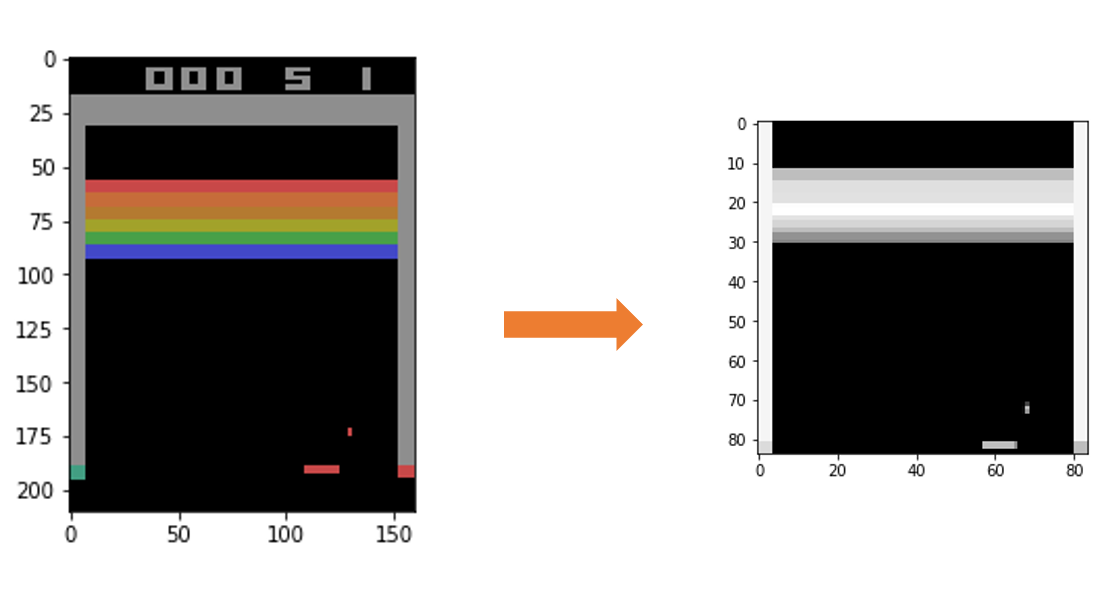
</div>

---

## <center> Optimizer

<center>Now we will define the Optimizer or as some may call it the Trainer. This class will take care of the training. It will run the episodes and store the experiences in the buffer. After a given amount of steps it will sample from the buffer and perform a gradient descent step. The training will optimize the huber loss between the predicted $Q$-Values and the target $y$. At first we will define $y$ as follows:

$$ \Large y = r(a_t,s_t) + \gamma *  \underset{a_{t'}}{max}\ Q_\theta(s_{t'}, a_{t'})$$

<center>Here $\theta$ denotes our network. As you may notice $y$ depends on the $Q$-Values of the next state. These are not stationary and depend on our model $\theta$. Therefore it seems that the model is "chasing its own tail". To address this issue we will incorporate a second network (target network) which will be used to predict the $Q$-Values of the next state. The target network was not specified in the original paper but is considered state-of-the-art nowadays. The target network will not have its own training. It will have the same weights as the main network, but will lag behind a given amount of steps. Alternatively we can compute a moving average between the target and the main network, but to keep the computations lean and the performance fast, we will stick to the simpler lag version. Our new target looks as follows:

$$ \Large y = r(a_t,s_t) + \gamma *  \underset{a_{t'}}{max}\ Q_{\theta'}(s_{t'}, a_{t'})$$

<center>Here $\theta'$ denotes the target network. Now we will also introduce the method called Doubel $Q$-Learning. This will stabilize the training and helps the network to predict more accurate $Q$-Values. Our final objective function looks as follows:

$$ \Large y = r(a_t,s_t) + \gamma * Q_{\theta'}(s_{t'}, \underset{a_{t'}}{arg\ max}\ Q_{\theta}(s_{t'}, a_{t'}))$$

<center>Here you can see that we reintroduced our main model $\theta$ to select the best action, but still use the target network $\theta'$ to evaluate the $Q$-Values. 

<center><b> Please refer to the references at the end of this notebook to get a comprehensive explanation on Doubel $Q$-Learning and the target network.

In [ ]:
class Optimizer():    
    """
    Optimizer to train the DQN
    
    Args:
        model: model to train. the model should already been built
        opt: tf optimizer e.g. Adam with a low learining rate e.g. 0.00001. 
             The opt is initialized externally for simpler pickling            
        gamma: discout factor for future rewards
        buffer_size: nuber of experiences to store. 
        epsilon_strategy: start, end and decay rate for exploration
        update_target_steps: number of steps after which the weights are copied to the target
        n_frames: nubmer of frames for one observation
    """
    def __init__(self,model, opt, gamma = 0.99, buffer_size = 100000,
               epsilon_strategy = (0.9, 0.1, 50000*10), 
               update_target_steps = 1000, n_frames = 4):
        #Set epsilon params
        self.epsilon_start = epsilon_strategy[0]
        self.epsilon_end = epsilon_strategy[1]
        self.epsilon_rate = epsilon_strategy[2]
        
        #Set models
        self.net = model
        self.target_net = copy.deepcopy(model)
        self.update_target_steps = update_target_steps
        
        #Set other params
        self.step = 0
        self.gamma = gamma
        self.optimizer = opt

        #Set metric tracker
        self.avg_total_reward = tf.keras.metrics.Mean()
        self.avg_Q_values  = tf.keras.metrics.Mean()
        self.avg_loss  = tf.keras.metrics.Mean()
        self.avg_steps  = tf.keras.metrics.Mean()
        self.buffer = ReplayBuffer(buffer_size,n_frames = n_frames)
        self.n_frames = n_frames
      
    
    def _get_epsilon(self):
        """
        Returns the exponentially decayed epsilon
        """
        return self.epsilon_end + (self.epsilon_start - self.epsilon_end) * tf.math.exp(-1. * self.step / self.epsilon_rate)

    
    def get_action(self, q_values, action_space):
        """
        Returns a random action or the greedy action corresponding to the set epsilon greedy strategy 
        
        Args:
            q_values: predicted Q-Values for the current state
            action_space: number of possible actions
        """
        #Get current epsilon
        eps = self._get_epsilon()
        
        #Return random action
        if eps > np.random.uniform():
            action = np.random.choice(action_space)
        #Return greedy action
        else: 
            action = tf.math.argmax(q_values, axis = 1).numpy()
        return action
  
  
    def logging(self,e):
        """
        Prints various metrics to the console
        
        Args:
            e: current epoch
        """
        print(f'{datetime.now().strftime("%Y-%m-%d %H:%M")}: Epoch: {e+1}, '+\
            f'Avg Loss: {self.avg_loss.result():.4f}, '+\
            f'Avg reward: {self.avg_total_reward.result():.4f}, '+\
            f'Avg Q: {self.avg_Q_values.result():.4f}, '+\
            f'Epsilon: {self._get_epsilon():.4f}, '+\
            f'Avg steps/episode: {self.avg_steps.result():.1f}, '+\
            f'Total step = {self.step} ')

        
    @tf.function
    def train(self, obs, reward, action, terminal, next_obs):
        """
        Performs a gradient descent step for given batch
        
        Args:
            obs: states from sampled batch (batch with stacks of n frames)
            reward: rewards from sampled batch
            action: actions from sampled batch
            terminal: flags for terminal state from sampled batch
            next_obs: next states from sampled batch (batch with stacks of n frames)
        """
        #Compute target with Double Q-Learning:
        #Get arg max of Qs for the next state with main network
        next_q_values = self.net(next_obs)
        col_idx = tf.argmax(next_q_values, axis = 1, output_type= 'int32')
        row_idx = tf.range(tf.shape(col_idx)[0], dtype ='int32')
        q_idx = tf.stack([row_idx,col_idx],axis = 1)
        
        #Evaluate the Qs with target network
        next_q_vaules_target = tf.gather_nd(self.target_net(next_obs),q_idx)
        
        #Compute target variable
        y = reward + (1- terminal) * self.gamma * next_q_vaules_target
        
        #Compute the loss and backpropagat through network
        with tf.GradientTape() as tape:
            idx = tf.stack([tf.range(tf.shape(action)[0], dtype ='int32'), action], axis = 1)
            pred = tf.gather_nd(self.net(obs),idx)
            loss = tf.keras.losses.huber(y,pred)
        gradients = tape.gradient(loss, self.net.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.net.trainable_variables))
        return loss
    

    def update_target(self):
        """
        Copies the weights of the main network to the target network
        """
        w = self.net.get_weights()
        self.target_net.set_weights(w)
      
    
    def run(self, env, epochs, episodes, env_steps = 16 ,
            warmup = 10000,  batch_size = 128, save_after = 10,
            save_dir = 'breakout_training'):
        """
        Runs the complete training for multiple epochs
        
        Args:
            env: Atari gym environment to run the game
            epochs: number of epochs for the training
            episodes: number of episodes per epoch
            env_steps: number of steps the environment makes for a single GD step. Do not set bellow 8 due to overfitting
            warmup: number of steps to fill the buffer before training starts
            batch_size: size of the batch for the update
            save_after: number of epochs after which the model+opt is saved
            save_dir: directory where the model should be saved
        """
        done = False
        self.step = 0
        
        for e in range(epochs):
            for ep in range(episodes):
                
                #Start episode
                total_reward = 0
                frame = env.reset()
                
                #Make initial input for the agent i.e. stack frames
                frame = preprocess_image(frame)
                observation = np.stack([frame for f in range(self.n_frames)],axis = 2)
                observation = observation[np.newaxis,:,:,:,np.newaxis]
                done = False
                episode_step = 0
                
                #Run episode
                while not done:
                    self.step += 1
                    episode_step += 1
                    
                    #Get action
                    q_values = self.net(observation)
                    self.avg_Q_values(tf.math.reduce_max(q_values, axis = -1))
                    action = self.get_action(q_values, env.action_space.n)
                    
                    #Execute action
                    frame, reward, done, info = env.step(action)
                    
                    #Store experience
                    total_reward += reward
                    frame = preprocess_image(frame)
                    observation = np.roll(observation, -1, axis = 3)
                    observation[:,:,:,3,:] = frame[np.newaxis,:,:,np.newaxis]
                    self.buffer.store(frame,action,reward,done)
                    
                    #Make GD step
                    if(self.step > warmup and self.step % env_steps == 0 ):
                        s = self.buffer.sample(batch_size)
                        l = self.train(*s)
                        self.avg_loss(l)
                        
                    #Update target
                    if self.step > warmup and self.step %  self.update_target_steps == 0:
                        self.update_target()
                
                #Store metrics
                self.avg_total_reward(total_reward)
                self.avg_steps(episode_step)
                
                gc.collect()

            #Save model and opt to disk
            if e % save_after == 0 or e == epochs -1:
                timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
                name = 'model_' + timestamp + '_' + str(e)
                filename = os.path.join(save_dir,name)
                self.net.save(filename)

                name = 'opt_' + timestamp + '_' + str(e) + '.pkl'
                filename = os.path.join(save_dir,name) 
                with open(filename, 'wb+') as f:               
                    pkl.dump(self.optimizer.get_weights(),f)
            
            #Finish epoch and log results to console
            self.logging(e)
            self.avg_total_reward.reset_states()
            self.avg_Q_values.reset_states()
            self.avg_loss.reset_states()
            self.avg_steps.reset_states()
            
        env.close()
        return 

---

## <center> Use trained models

<center>After the training will be finished we should be able to load the final model and use it to play Atari. The following function is used for this purpose.

In [ ]:
def play_atari(model, episodes, game = 'Breakout-v0', render = True, n_frames = 4):
    """
    Plays an Atari game with a given agent

    Args:
        model: the trained agent network
        episodes: number of episodes to play
        game: name of the gym environment / the game
        render: show the game on screen
        n_frames: number of frames to stack for the models input
    """
    total_reward = 0
    env = gym.make(game)
    
    #Run all episodes
    for e in range(episodes):
        #Start episode
        frame = env.reset()
        frame = preprocess_image(frame)
        
        #Make initial input for the agent.
        #as you make recall out model takes n  = 4 frames as input
        observation = np.stack([frame for f in range(n_frames)],axis = 2)
        observation = observation[np.newaxis,:,:,:,np.newaxis]
        done = False
        step = 0
        
        #Run the episode
        while not done:
            step +=1
            
            #Get action from agent network
            q_values = model(observation)
            action = tf.math.argmax(q_values, axis = 1).numpy().item()
            
            #Execute action in the environment
            frame, reward, done, info = env.step(action)
            
            #Render frame
            if render:
                env.render()
                time.sleep(0.05)
                
            total_reward += reward

            #Include new frame into given observation and remove the oldes frame
            frame = preprocess_image(frame)
            observation = np.roll(observation, -1, axis = 3)
            observation[:,:,:,3,:] = frame[np.newaxis,:,:,np.newaxis]

        #Close environment
        env.close()

---

## <center> Run training

<center> Now that we have everything set up, we can run the training of the model. The model will be saved in the directory 'breakout_training' every 5 epochs.  

In [ ]:
#Init environment
env = gym.make('Breakout-v0')

#Init network
network = DQN(env.action_space.n)
network.build((1,84,84,4,1))

#Init optimizer
lr = 0.000015
opt = tf.keras.optimizers.Adam(learning_rate=lr) 


#Init optimizer
optimizer = Optimizer(network,
                      opt,
                      buffer_size = 100000,
                      epsilon_strategy = (0.9, 0.1, 250000),
                      update_target_steps = 1000,
                      gamma = 0.99)

#Run training
optimizer.run(env, 2, 2, warmup = 100, batch_size = 32, save_after = 5, env_steps = 8,save_dir = 'breakout_training')

---

# <center> Play Breakout 

<center> Load finished model to watch it play

In [ ]:
model_path = r'.\model'
network = tf.keras.models.load_model(model_path)
play_atari(network, 1)

---

# <center> References

Mnih, Volodymyr, et al. Playing atari with deep reinforcement learning. arXiv preprint arXiv:1312.5602. 2013<br>
https://arxiv.org/pdf/1312.5602.pdf?source=post_page---------------------------
<br><br><br>
Levine, Sergey. Deep Reinforcement Learning. CS 285 at UC Berkeley. 2020 <br> 
http://rail.eecs.berkeley.edu/deeprlcourse/
<br><br><br>
Schmidt-Thieme, Lars. Deep Learning Lecture. ISMLL. 2020 <br>
https://www.ismll.uni-hildesheim.de/lehre/dl-20s/script/index_en.html
<br>